# Manufacturing Inspection
In this assignment you will apply simple image processing techniques to determine the level of liquid in a bottle.
This simple approach allows us to identify overfilled bottles on a production line.

![link text](https://github.com/tonyscan6003/etivities/blob/main/manu_inspect.JPG?raw=true)



Before beginning this exercise you should think about and engage with your peers (on the forum) about the likely sequence of steps necessary to complete the exercise. As you make progress you can discuss what approaches are working well or are failing. Some useful information is provided below. Much of the necessary code can be found in the example notebooks provided.

*   [OpenCV2 Threshold](https://docs.opencv.org/4.5.1/d7/d4d/tutorial_py_thresholding.html) (example of use here)
*   [OpenCV2 Morphology Operations](https://docs.opencv.org/4.5.2/d9/d61/tutorial_py_morphological_ops.htmlf) (example of use here)
*   [Canny Algorithm](https://docs.opencv.org/3.4/da/d22/tutorial_py_canny.html) (example of use)
*   [Hough Algorithm](https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html) (example of use)





#Housekeeping:
Import packages, read test image, define helper functions.

In [12]:
import numpy as np
from skimage import feature
from scipy import signal
import cv2
import matplotlib.pyplot as plt
import urllib.request


In [13]:
# function to read images from Web addresses.
def url_to_image(url):
	resp = urllib.request.urlopen(url)
	temp_image = np.asarray(bytearray(resp.read()), dtype="uint8")
	temp_image = cv2.imdecode(temp_image, cv2.IMREAD_COLOR)
	temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB) # OpenCV defaults to BGR, but we need RGB
	return temp_image

A Mask for the Region of Interest containing specific edges from the image can be created using the cv2.fillPoly command that can create a a filled region, the number of sides of the region is determined by the number of vertices applied. If a rectangle is required then 4 vertices are needed.

In [14]:
"""
# In order to create a rectangular mask 4 points are needed
# These are arranged clockwise (starting at any corner of the rectangle).
# NB Coordinates are given in the form (width,height) with the origin in the top left

e.g.
l1 = [50,150]
l2 = [50,20]
r1 = [400,20]
r2 = [400,150]

# The coodinates are converted to an array that is given to the mask function
# along with the input image, both the mask and masked image are returned.
vertices = np.array([[l1,l2,r1,r2 ]], dtype=np.int32)
"""
#Mask region of Interest.
def mask_img(image,vertices):
    #Create mask
    mask = np.zeros_like(image)
    #Add white to region of interest
    cv2.fillPoly(mask, vertices, 255)
    # apply mask to image
    masked_image = cv2.bitwise_and(image,image, mask=mask)
    return mask,masked_image

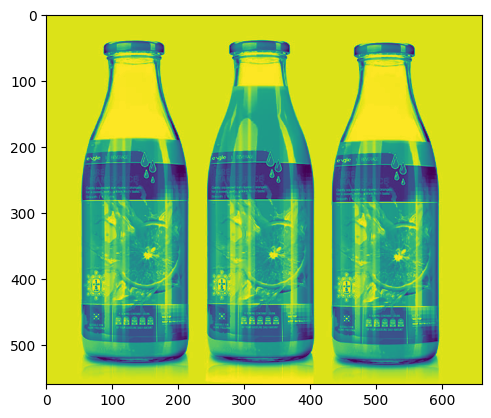

In [15]:
# read in test image
image_url = "https://cdn.eaglepi.com/uploads/2016/08/NEW_Fill_level_Rounded_Image_660pxh.jpg"

image = url_to_image(image_url)
plt.imshow(image)
# Convert to greyscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)

# Method

In the code cells below apply various techniques sequentially to find the fluid levels of the bottles.

You should be able to extract the fluid levels in the bottles in the form of a line(s) (line defined by two points in open CV)

Step 1

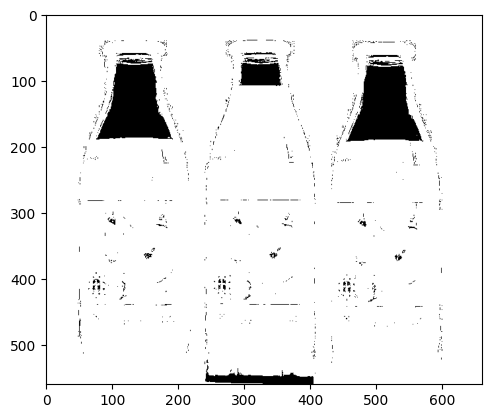

In [16]:
# Apply thresholding
ret, thresh = cv2.threshold(gray, 245, 255, cv2.THRESH_BINARY_INV)

# Display the binary image
plt.imshow(thresh, cmap='gray')


Step 2...

In [17]:
# Define a kernel for the closing operation
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
erode  = cv2.erode(thresh[1], kernel)

# Apply closing operation
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

Step N

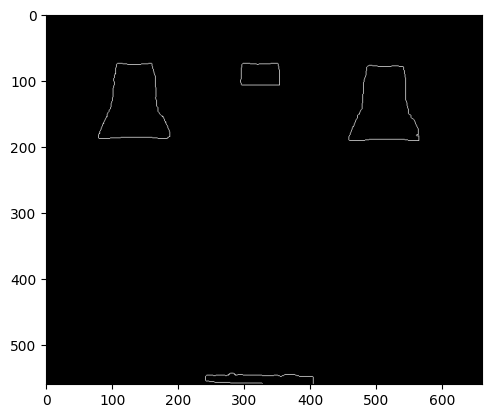

In [18]:
# Find edges in the closed image
edges = cv2.Canny(closing, 50, 150)

# Display the edges
plt.imshow(edges, cmap='gray')

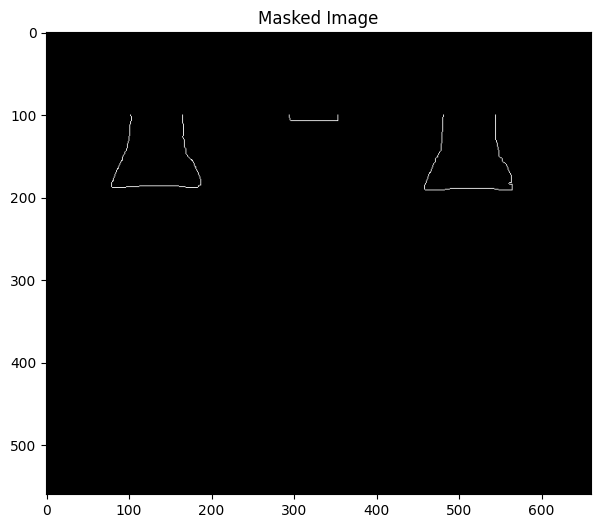

In [19]:
# Get the width and height of the image
height,width,chl = image.shape

# Use the mask_img function to remove the disturbance of the bottle cap, leaving only the bottle body and the bottom of bottle
l1 = [0,height]
l2 = [0,100]
r1 = [width,100 ]
r2 = [width,height]
vertices = np.array([[l1,l2,r1,r2 ]], dtype=np.int32)
# Apply mask function
mask, masked_image = mask_img(edges, vertices)

# Use the mask_img function to remove the disturbance of the bottom of the bottle, leaving only the bottle body
l1 = [0,height-100]
l2 = [0,100]
r1 = [width,100]
r2 = [width,height-100]
vertices = np.array([[l1,l2,r1,r2 ]], dtype=np.int32)
masked, masked_image = mask_img(edges,vertices)


fig, ax = plt.subplots(figsize=(10, 6))


ax.imshow(masked_image, 'gray')
ax.set_title('Masked Image')

# Display the edges
#plt.imshow(masked_image, cmap='gray')
plt.show()

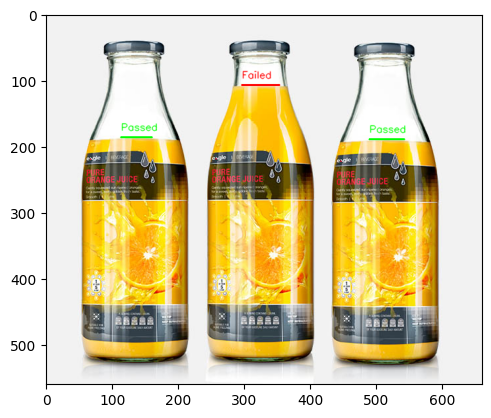

In [20]:
# Reload image
image = url_to_image(image_url)

# Use the HoughLinesP function to identify line segments
lines = cv2.HoughLinesP(masked_image, 1, 5*np.pi/180, 50, minLineLength=10, maxLineGap=10)
if lines is not None:
    for line in lines:
        # Get the endpoint coordinates of the line segment
        x1, y1, x2, y2 = line[0]

        # Calculate the slope of the line segment, keeping only the horizontal liquid level
        slope = abs((y2 - y1) / (x2 - x1))
        if slope < 1:
            # According to the liquid level to determine whether to pass
            if 180<y1<220:
                cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                center_x = int(x1)
                center_y = int((y1 + y2) / 2)
                cv2.putText(image, "Passed", (center_x, center_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1,
                            cv2.LINE_AA)
            else:
                cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
                center_x = int(x1)
                center_y = int((y1 + y2) / 2)
                cv2.putText(image, "Failed", (center_x, center_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1,
                            cv2.LINE_AA)

# Display the image with lines
plt.imshow(image)

#Display

Display the image with the fluid levels overlaid (as in image at the top of the notebook) or otherwise mark the overfilled bottle as Failed or Passed.

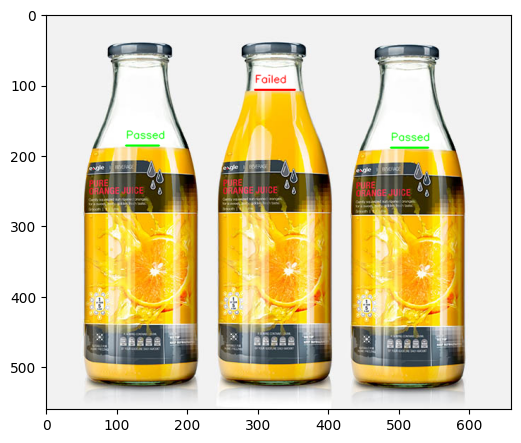

In [21]:
out = url_to_image(image_url)
f, axarr = plt.subplots(1,1,figsize=(6,6))
x_step =130

out = image


axarr.imshow(out)

